In [1]:
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
import scipy.stats as stats

from backend.functions import *

In [2]:
###############################################################################
#                         Load data
###############################################################################

with open( f"../pickles/Radius 10 um/-2V_3.pkl", "rb" ) as file:
    df2 = pickle.load( file )

with open( f"../pickles/Radius 10 um/-3V_2.pkl", "rb" ) as file:
    df3 = pickle.load( file )

with open( f"../pickles/Radius 10 um/-4V_1.pkl", "rb" ) as file:
    df4 = pickle.load( file )

df = df2
time = np.array( df[ "t" ].to_list() )
current = np.array( df[ "I" ].to_list() )
voltage = np.array( df[ "V" ].to_list() )

print( "Timestep", np.mean( np.diff( time ) ) )

Timestep 0.08443631563333334


In [3]:
###############################################################################
#                         Define model
###############################################################################

V = Interpolated( time, voltage )


def I( t, x,
       gmax_p, bmax_p, gmax_n, bmax_n,
       gmin_p, bmin_p, gmin_n, bmin_n ):
    v = V( t )

    i = np.where( v >= 0,
                  gmax_p * np.sinh( bmax_p * v ) * x + gmin_p * np.sinh( bmin_p * v ) * (1 - x),
                  gmax_n * np.sinh( bmax_n * v ) * x + gmin_n * np.sinh( bmin_n * v ) * (1 - x)
                  )

    return i


def g( v, Ap, An, Vp, Vn ):
    return np.select( [ v > Vp, v < -Vn ],
                      [ Ap * (np.exp( v ) - np.exp( Vp )),
                        -An * (np.exp( -v ) - np.exp( Vn )) ],
                      default=0 )


def wp( x, xp ):
    return ((xp - x) / (1 - xp)) + 1


def wn( x, xn ):
    return x / xn


def f( v, x, xp, xn, alphap, alphan, eta ):
    return np.select( [ eta * v >= 0, eta * v < 0 ],
                      [ np.select( [ x >= xp, x < xp ],
                                   [ np.exp( -alphap * (x - xp) ) * wp( x, xp ),
                                     1 ] ),
                        np.select( [ x <= xn, x > xn ],
                                   [ np.exp( alphan * (x - xn) ) * wn( x, xn ),
                                     1 ] )
                        ] )


def dxdt( t, x, Ap, An, Vp, Vn, xp, xn, alphap, alphan, eta=1 ):
    v = V( t )

    return eta * g( v, Ap, An, Vp, Vn ) * f( v, x, xp, xn, alphap, alphan, eta )

In [4]:
###############################################################################
#                         Functions
###############################################################################

def simulate( params_dxdt, params_I ):
    x_fitted = solver( dxdt, time_sim, dt, x0, method="Euler", args=params_dxdt )
    time_fitted = time
    current_fitted = I( time_fitted, x_fitted, *params_I )
    voltage_fitted = V( time_fitted )

    return x_fitted, time_fitted, current_fitted, voltage_fitted


def error( current_fitted ):
    error = np.sum( np.abs( current - current_fitted ) )
    error_average = np.mean( error )
    error_percent = 100 * error / np.sum( np.abs( current_fitted ) )
    error_string = f"{order_of_magnitude.symbol( error_average )[ 2 ]}A ({np.mean( error_percent ):.2f} %)"

    print( "Average error " + error_string )

    return error_string


def plot_fitting( voltage_fitted, current_fitted, title, error_string ):
    plt.figure()
    plt.title( "I-V comparison " + title )
    plt.plot( voltage, np.multiply( current, 1000 ), c="r", label="data" )
    plt.plot( voltage_sim, np.multiply( current_sim, 1000 ), c="k", label="sim" )
    plt.plot( voltage_fitted, np.multiply( current_fitted, 1000 ), c="g", label="fit" )
    plt.annotate( "Average error " + error_string, xy=(0.5, 0.3), xycoords="figure fraction" )
    plt.legend()
    plt.xlabel( "Voltage (V)" )
    plt.ylabel( "Current (mA)" )
    plt.show()

In [5]:
###############################################################################
#                         Define parameters
###############################################################################

Ap = 90
An = 10

Vp = 0.5
Vn = 0.5

xp = 0.1
xn = 0.242

alphap = 1
alphan = 1

gmax_p = 9e-5
bmax_p = 4.96
gmax_n = 1.7e-4
bmax_n = 3.23
gmin_p = 1.5e-5
bmin_p = 6.91
gmin_n = 4.4e-7
bmin_n = 2.6

x0 = 0

eta = 1

dt = 1 / 10000
# dt = np.mean( np.diff( time ) )

params_dxdt = np.array( [ Ap, An, Vp, Vn, xp, xn, alphap, alphan ] )
params_I_on = np.array( [ gmax_p, bmax_p, gmax_n, bmax_n ] )
params_I_off = np.array( [ gmin_p, bmin_p, gmin_n, bmin_n ] )
params_I = np.concatenate( (params_I_on, params_I_off) )
params_all = np.concatenate( (params_dxdt, params_I) )

In [8]:
###############################################################################
#                         Simulate
###############################################################################

x = solver( dxdt, time, dt, x0, params_dxdt )
time_sim = time

# x_solve_ivp = solve_ivp( dxdt, (time[ 0 ], time[ -1 ]), [ x0 ], method="LSODA", t_eval=time, args=params_dxdt )
# x = x_solve_ivp.y[ 0, : ]
# t = x_solve_ivp.t

# x_solve_ivp = solve_ivp( dxdt, (time[ 0 ], time[ -1 ]), [ x0 ], method="LSODA", t_eval=time )
# x = x_solve_ivp.y[ 0, : ]
# time_sim = x_solve_ivp.t

current_sim = I( time_sim, x, *params_I )
voltage_sim = V( time_sim )

<ipython-input-9-6da789709081>:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


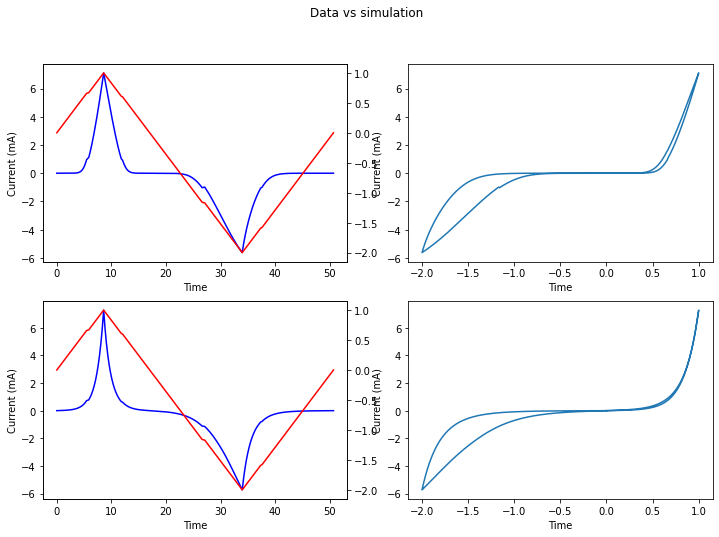

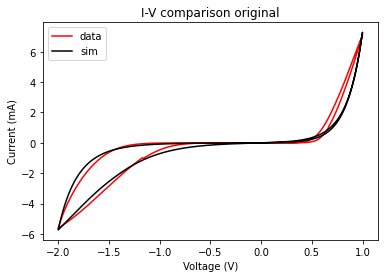

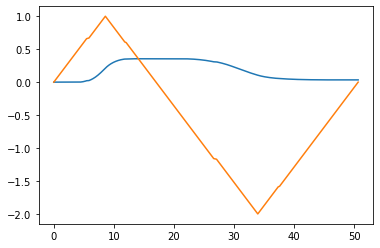

In [9]:
###############################################################################
#                         Plot simulation
###############################################################################

fig, axes = plt.subplots( 2, 2, figsize=(12, 8) )
fig.suptitle( "Data vs simulation" )
axes[ 0, 0 ].plot( time, np.multiply( current, 1000 ), c="b" )
axv1 = axes[ 0, 0 ].twinx()
axv1.plot( time, voltage, c="r" )
axes[ 0, 1 ].plot( voltage, np.multiply( current, 1000 ) )
axes[ 1, 0 ].plot( time_sim, np.multiply( current_sim, 1000 ), c="b" )
axv2 = axes[ 1, 0 ].twinx()
axv2.plot( time_sim, voltage_sim, c="r" )
axes[ 1, 1 ].plot( voltage_sim, np.multiply( current_sim, 1000 ) )
for ax in axes.flatten():
    ax.set_xlabel( "Time" )
    ax.set_ylabel( "Current (mA)" )
fig.show()

plt.figure()
plt.title( "I-V comparison original" )
plt.plot( voltage, np.multiply( current, 1000 ), c="r", label="data" )
plt.plot( voltage_sim, np.multiply( current_sim, 1000 ), c="k", label="sim" )
plt.legend()
plt.xlabel( "Voltage (V)" )
plt.ylabel( "Current (mA)" )
plt.show()

plt.figure()
plt.plot( time_sim, x )
plt.plot( time_sim, voltage_sim )
plt.show()

fit = False

In [14]:
np.max( x )

0.0

Fitting dxdt parameters
Original vs fitted dxdt parameters 
	 [90.    10.     0.5    0.5    0.1    0.242  1.     1.   ] 
	 [1.66094302e+02 7.25855169e+00 1.75544654e-01 7.20626367e-06
 2.11740271e-01 1.52887823e-01 1.66870045e+01 1.47324239e+01]
Average error 1.3 dA (18.53 %)


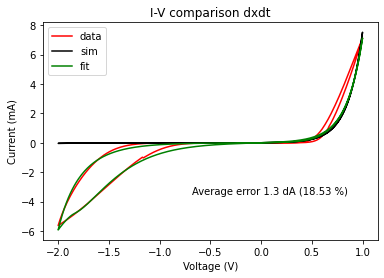

In [15]:
###############################################################################
#                         Fit dxdt
###############################################################################

def fit_dxdt():
    def ode_fitting( t,
                     Ap, An, Vp, Vn, xp, xn, alphap, alphan
                     ):
        params_dxdt = [ Ap, An, Vp, Vn, xp, xn, alphap, alphan ]

        x = solver( dxdt, time, dt, x0, params_dxdt )

        return I( t, x, *params_I )

    return ode_fitting


title = "dxdt"
print( "Fitting " + title + " parameters" )

# Fit parameters to real data starting from hand-defined model
par_fitted_dxdt, pcov = curve_fit( fit_dxdt(),
                                   time,
                                   current,
                                   bounds=(
                                           0,
                                           [ np.inf, np.inf,
                                             np.max( voltage ), -np.min( voltage ),
                                             1, 1,
                                             np.inf, np.inf ]
                                           ),
                                   p0=params_dxdt,
                                   # maxfev=100000
                                   )

print( "Original vs fitted " + title + " parameters",
       "\n\t",
       params_dxdt,
       "\n\t",
       par_fitted_dxdt,
       )

# Simulate with fitted parameters
x_fitted, time_fitted, current_fitted, voltage_fitted = simulate( par_fitted_dxdt, params_I )

# calculate error in fitted current
error_string = error( current_fitted )

# Plot fitted data
plot_fitting( voltage_fitted, current_fitted, title, error_string )

Fitting I-V parameters
Original vs fitted I-V parameters 
	 [9.00e-05 4.96e+00 1.70e-04 3.23e+00 1.50e-05 6.91e+00 4.40e-07 2.60e+00] 
	 [2.32143568e-04 4.67533219e+00 1.76070610e-04 3.19867088e+00
 7.38604225e-05 5.22757062e+00 5.82497313e-06 2.68599566e+00]
Average error 1.1 dA (13.89 %)


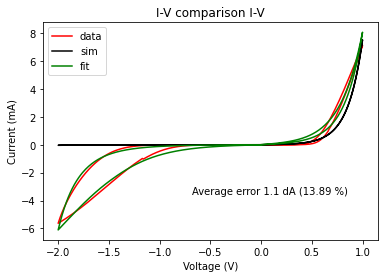

In [16]:
###############################################################################
#                         Fit I-V
###############################################################################

def fit_iv():
    def ode_fitting( t,
                     gmax_p, bmax_p, gmax_n, bmax_n,
                     gmin_p, bmin_p, gmin_n, bmin_n
                     ):
        params_I = [ gmax_p, bmax_p, gmax_n, bmax_n,
                     gmin_p, bmin_p, gmin_n, bmin_n ]

        x = solver( dxdt, time, dt, x0, params_dxdt )

        return I( t, x, *params_I )

    return ode_fitting


title = "I-V"
print( "Fitting " + title + " parameters" )

# Fit parameters to real data starting from hand-defined model
par_fitted_I, pcov = curve_fit( fit_iv(),
                                time,
                                current,
                                bounds=(-np.inf, np.inf),
                                p0=params_I,
                                # maxfev=100000
                                )

print( "Original vs fitted " + title + " parameters",
       "\n\t",
       params_I,
       "\n\t",
       par_fitted_I,
       )

# Simulate with fitted parameters
x_fitted, time_fitted, current_fitted, voltage_fitted = simulate( params_dxdt, par_fitted_I )

# calculate error in fitted current
error_string = error( current_fitted )

# Plot fitted data
plot_fitting( voltage_fitted, current_fitted, title, error_string )

In [ ]:
###############################################################################
#                         Fit all
###############################################################################

def fit_all():
    def ode_fitting( t,
                     Ap, An, Vp, Vn, xp, xn, alphap, alphan,
                     gmax_p, bmax_p, gmax_n, bmax_n,
                     gmin_p, bmin_p, gmin_n, bmin_n
                     ):
        params_dxdt = [ Ap, An, Vp, Vn, xp, xn, alphap, alphan ]
        params_I = [ gmax_p, bmax_p, gmax_n, bmax_n,
                     gmin_p, bmin_p, gmin_n, bmin_n ]

        x = solver( dxdt, time, dt, x0, params_dxdt )

        return I( t, x, *params_I )

    return ode_fitting


title = "all"
print( "Fitting " + title + " parameters" )

# Fit parameters to real data starting from hand-defined model
par_fitted, pcov = curve_fit( fit_all(),
                              time,
                              current,
                              bounds=([ 0 ] * 8 + [ -np.inf ] * 8,
                                      [ np.inf, np.inf,
                                        np.max( voltage ), -np.min( voltage ),
                                        1, 1,
                                        np.inf, np.inf ] +
                                      [ np.inf ] * 8),
                              p0=params_all,
                              # maxfev=100000
                              )
par_fitted_all_dxdt = par_fitted[ :len( params_dxdt ) ]
par_fitted_all_I = par_fitted[ len( params_dxdt ): ]

print( "Original vs fitted " + title + " parameters",
       "\n\t",
       params_dxdt,
       "\n\t",
       par_fitted_all_dxdt,
       "\n\t",
       params_I,
       "\n\t",
       par_fitted_all_I,
       )

# Simulate with fitted parameters
x_fitted, time_fitted, current_fitted, voltage_fitted = simulate( par_fitted_all_dxdt,
                                                                  par_fitted_all_I )

# calculate error in fitted current
error_string = error( current_fitted )

# Plot fitted data
plot_fitting( voltage_fitted, current_fitted, title, error_string )

Fitting all parameters


In [ ]:
###############################################################################
#                         Fit ON and OFF parameters
###############################################################################

def fit_iv_on():
    def ode_fitting( t,
                     gmax_p, bmax_p, gmax_n, bmax_n
                     ):
        params_I = [ gmax_p, bmax_p, gmax_n, bmax_n ]

        x = solver( dxdt, time, dt, x0, params_dxdt )

        return I( t, x, *params_I, *params_I_off )

    return ode_fitting


def fit_iv():
    def ode_fitting( t,
                     gmin_p, bmin_p, gmin_n, bmin_n
                     ):
        params_I = [ gmin_p, bmin_p, gmin_n, bmin_n ]

        x = solver( dxdt, time, dt, x0, params_dxdt )

        return I( t, x, *params_I_on, *params_I )

    return ode_fitting


def mim_mim_iv( v, gp, bp, gn, bn ):
    return np.piecewise( v,
                         [ v >= 0, v < 0 ],
                         [ lambda v: gp * np.sinh( bp * v ), lambda v: gn * np.sinh( bn * v ) ] )


title = "ON and OFF"
print( "Fitting " + title + " parameters" )

on_mask = ((voltage > 0) & (np.gradient( voltage ) < 0)) | (
        (voltage < 0) & (np.gradient( voltage ) < 0) & (voltage > params_dxdt[ 3 ]))
off_mask = ((voltage < 0) & (np.gradient( voltage ) > 0)) | (
        (voltage > 0) & (np.gradient( voltage ) > 0) & (voltage < -params_dxdt[ 2 ]))

params_fitted_I_on, _ = scipy.optimize.curve_fit( mim_mim_iv, voltage[ on_mask ], current[ on_mask ],
                                                  p0=params_I_on )
params_fitted_I_off, _ = scipy.optimize.curve_fit( mim_mim_iv, voltage[ off_mask ], current[ off_mask ],
                                                   p0=params_I_off )

print( "Original vs fitted parameters\n",
       "\n\t",
       params_I_on,
       "\n\t",
       params_fitted_I_on,
       "\n\t",
       params_I_off,
       "\n\t",
       params_fitted_I_off
       )

# Solve ODE iteratively using Euler's method
x_fitted, time_fitted, current_fitted, voltage_fitted = simulate( params_dxdt,
                                                                  np.concatenate( (params_I_on, params_I_off) ) )

# calculate error in fitted current
error_string = error( current_fitted )

# Plot fitted data
plot_fitting( voltage_fitted, current_fitted, title, error_string )
